In [1]:
!pip install torch==2.2.0 numpy==1.24.4 matplotlib==3.7.4

  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached matplotlib-3.7.4-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.7 kB)
  Using cached contourpy-1.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 305.9 kB/s eta 0:00:001m299.8 kB/s eta 0:00:01
  Using cached kiwisolver-1.4.5-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached pillow-10.2.0-cp38-cp38-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached matplotlib-3.7.4-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.2 MB)
Using cached contourpy-1.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014

## Installing the data set

If you are a MacOS or Linux user, you can install the dataset by running the following commmand in your terminal:

```bash
curl -O https://www.gutenberg.org/files/1268/1268-0.txt
```

or uncomment the following cell and run it.

## Preprocessing the data

In [2]:
import numpy as np
import os

with open(os.path.join('data', '1268-0.txt'), 'r', encoding="utf8") as fp:
    text = fp.read()

start_idx = text.find('THE MYSTERIOUS ISLAND')
end_idx = text.find('End of the Project Gutenberg')

text = text[start_idx:end_idx]

char_set = set(text)


print(f'Total Length: {len(text):,}')
print(f'Unique Characters: {len(char_set)}')

Total Length: 1,130,711
Unique Characters: 85


In [3]:
chars_sorted = sorted(char_set)

char2int = {ch: i for i, ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted)

text_encoded = np.array([char2int[char] for char in text], dtype=np.int32)

print(f'Text encoded shape: {text_encoded.shape}')
print(f'{text[:15]} == Encoding ==> {text_encoded[:15]}')

print(f'{text_encoded[15:21]} == Reversed ==> {text[15:21]}')

Text encoded shape: (1130711,)
THE MYSTERIOUS  == Encoding ==> [48 36 33  1 41 53 47 48 33 46 37 43 49 47  1]
[37 47 40 29 42 32] == Reversed ==> ISLAND


In [4]:
import torch
from torch.utils.data import Dataset

seq_length = 40
chunk_size = seq_length + 1

text_chunks = [text_encoded[i:i+chunk_size]
               for i in range(len(text_encoded) - chunk_size)]


class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)

    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long()


seq_dataset = TextDataset(torch.tensor(text_chunks))

/tmp/ipykernel_7714/2909004157.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  seq_dataset = TextDataset(torch.tensor(text_chunks))


In [5]:
from torch.utils.data import DataLoader

batch_size = 64

torch.manual_seed(1)

seq_dl = DataLoader(seq_dataset, batch_size=batch_size,
                    shuffle=True, drop_last=True)

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Building the model

In [7]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, rnn_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)

        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        
        return hidden.to(device), cell.to(device)
    
vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size)
model = model.to(device)
model

RNN(
  (embedding): Embedding(85, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=85, bias=True)
)

## Training the model

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10000

torch.manual_seed(1)
losses = []
for epoch in range(num_epochs):
    hidden, cell = model.init_hidden(batch_size)
    
    seq_batch, target_batch = next(iter(seq_dl))
    
    seq_batch = seq_batch.to(device)
    target_batch = target_batch.to(device)
    
    optimizer.zero_grad()
    loss = 0
    
    for c in range(seq_length):
        pred, hidden, cell = model(seq_batch[:, c], hidden, cell)
        loss += loss_fn(pred, target_batch[:, c])
        
    loss.backward()
    optimizer.step()
    
    loss = loss.item() / seq_length
    losses.append(loss)
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch} loss; {loss:.4f}')

Epoch 0 loss; 4.4368
Epoch 500 loss; 1.3707
Epoch 1000 loss; 1.2536
Epoch 1500 loss; 1.2927
Epoch 2000 loss; 1.2025
Epoch 2500 loss; 1.2074
Epoch 3000 loss; 1.1859
Epoch 3500 loss; 1.1644
Epoch 4000 loss; 1.1805
Epoch 4500 loss; 1.1672
Epoch 5000 loss; 1.1427
Epoch 5500 loss; 1.0837
Epoch 6000 loss; 1.1890
Epoch 6500 loss; 1.1577
Epoch 7000 loss; 1.1731
Epoch 7500 loss; 1.1391
Epoch 8000 loss; 1.1634
Epoch 8500 loss; 1.1191
Epoch 9000 loss; 1.0949
Epoch 9500 loss; 1.2118


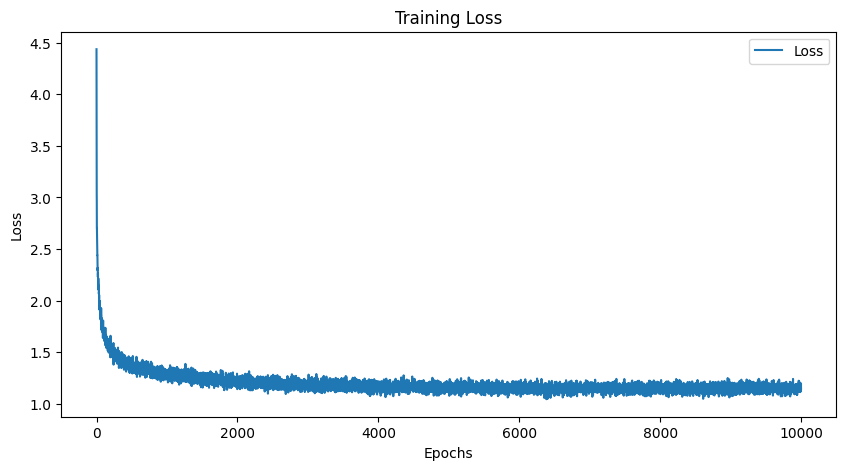

In [10]:
import matplotlib.pyplot as plt
import os

x = np.linspace(0, num_epochs, len(losses), endpoint=True)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(x, losses, label='Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend(loc='best')
plt.show()

if not os.path.exists('assets'):
    os.mkdir('assets')
fig.savefig(os.path.join('assets', 'training_loss.png'))


In [11]:
if not os.path.exists('models'):
    os.mkdir('models')

if not os.path.exists(os.path.join('models', 'rnn_model.pth')):    
    torch.save(model.state_dict(), os.path.join('models', 'rnn_model.pth'))
    
model = RNN(vocab_size, embed_dim, rnn_hidden_size)
model.load_state_dict(torch.load(os.path.join('models', 'rnn_model.pth')))
model = model.to(device)

## Evaluation

In [14]:
from torch.distributions.categorical import Categorical


def sample(mode, starting_str, len_generated_text=500, scale_factor=1.0):
    encoded_input = torch.tensor([char2int[s] for s in starting_str])
    encoded_input = torch.reshape(encoded_input, (1, -1))

    generated_str = starting_str

    model.eval()
    hidden, cell = mode.init_hidden(1)

    hidden = hidden.to('cpu')
    cell = cell.to('cpu')

    for c in range(len(starting_str)-1):
        _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell)

    last_char = encoded_input[:, -1]

    for i in range(len_generated_text):
        logits, hidden, cell = model(last_char.view(1), hidden, cell)
        logits = torch.squeeze(logits, 0)

        scaled_logits = logits * scale_factor

        m = Categorical(logits=logits)
        last_char = m.sample()
        generated_str += str(char_array[last_char])

    return generated_str

torch.manual_seed(1)
model.to('cpu')
print(sample(model, starting_str='The island'))

The island is thousand, either that it might previously twelve at one of
the center of damp, sincilen, the lake was spare, the retreation on board the main. But the convicts would never a
fever, a distance of time.

Ayrton’s feccess, ready to makpy say, sneed,” said Pencroft, and Ayrton remained betwords to an hour of this man?”

“Can have thrown will you have not made out?”

Herbert might done.
There the report of the balloon, advanced or a certain up trapped for unless himself in its left fan, and also 
